### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

## Image preprocessing

In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from utils import Vessels, get_model
from keras.callbacks import ModelCheckpoint
# from skimage.filters import frangi # run very slow

In [42]:
#tf.config.run_functions_eagerly(True)
img_size = (1600,1600) # for now that's the only input shape that network process

In [56]:
X = []
y = []
z = []

images_dir = 'images'
targets_dir = 'manual1'
masks_dir = 'mask'

images = sorted(os.listdir(images_dir))
targets = sorted(os.listdir(targets_dir))
masks = sorted(os.listdir(masks_dir))

for img_dir, target_dir, mask_dir in zip(images, targets, masks):
    img = cv2.imread(os.path.join(images_dir, img_dir))
    img = cv2.resize(img, img_size)
    target = cv2.imread(os.path.join(targets_dir, target_dir), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, img_size)
    mask = cv2.imread(os.path.join(masks_dir, mask_dir), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    X.append(img)
    y.append(target)
    z.append(mask)

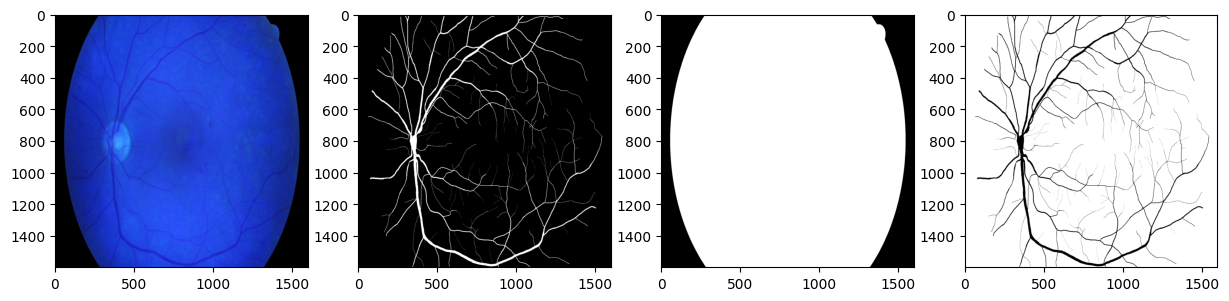

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].imshow(X[0], cmap='gray')
ax[1].imshow(y[0], cmap='gray')
ax[2].imshow(z[0] , cmap='gray')
ax[3].imshow((255-y[0]), cmap='gray')
plt.show()
# np.sum((y[0] < 255) & (y[0] > 0))

In [40]:
def sharpening(img):
    kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
    img_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img_sharp

In [61]:
def hist_equalization(img):
    ycrcb_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    return equalized_img

In [95]:
def edge_detection(img, lvl=25):
    edges = cv2.Canny(img, lvl, lvl)
    return edges

In [134]:
def denoising(img, convert=False):
    if convert:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    denoised = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    return denoised

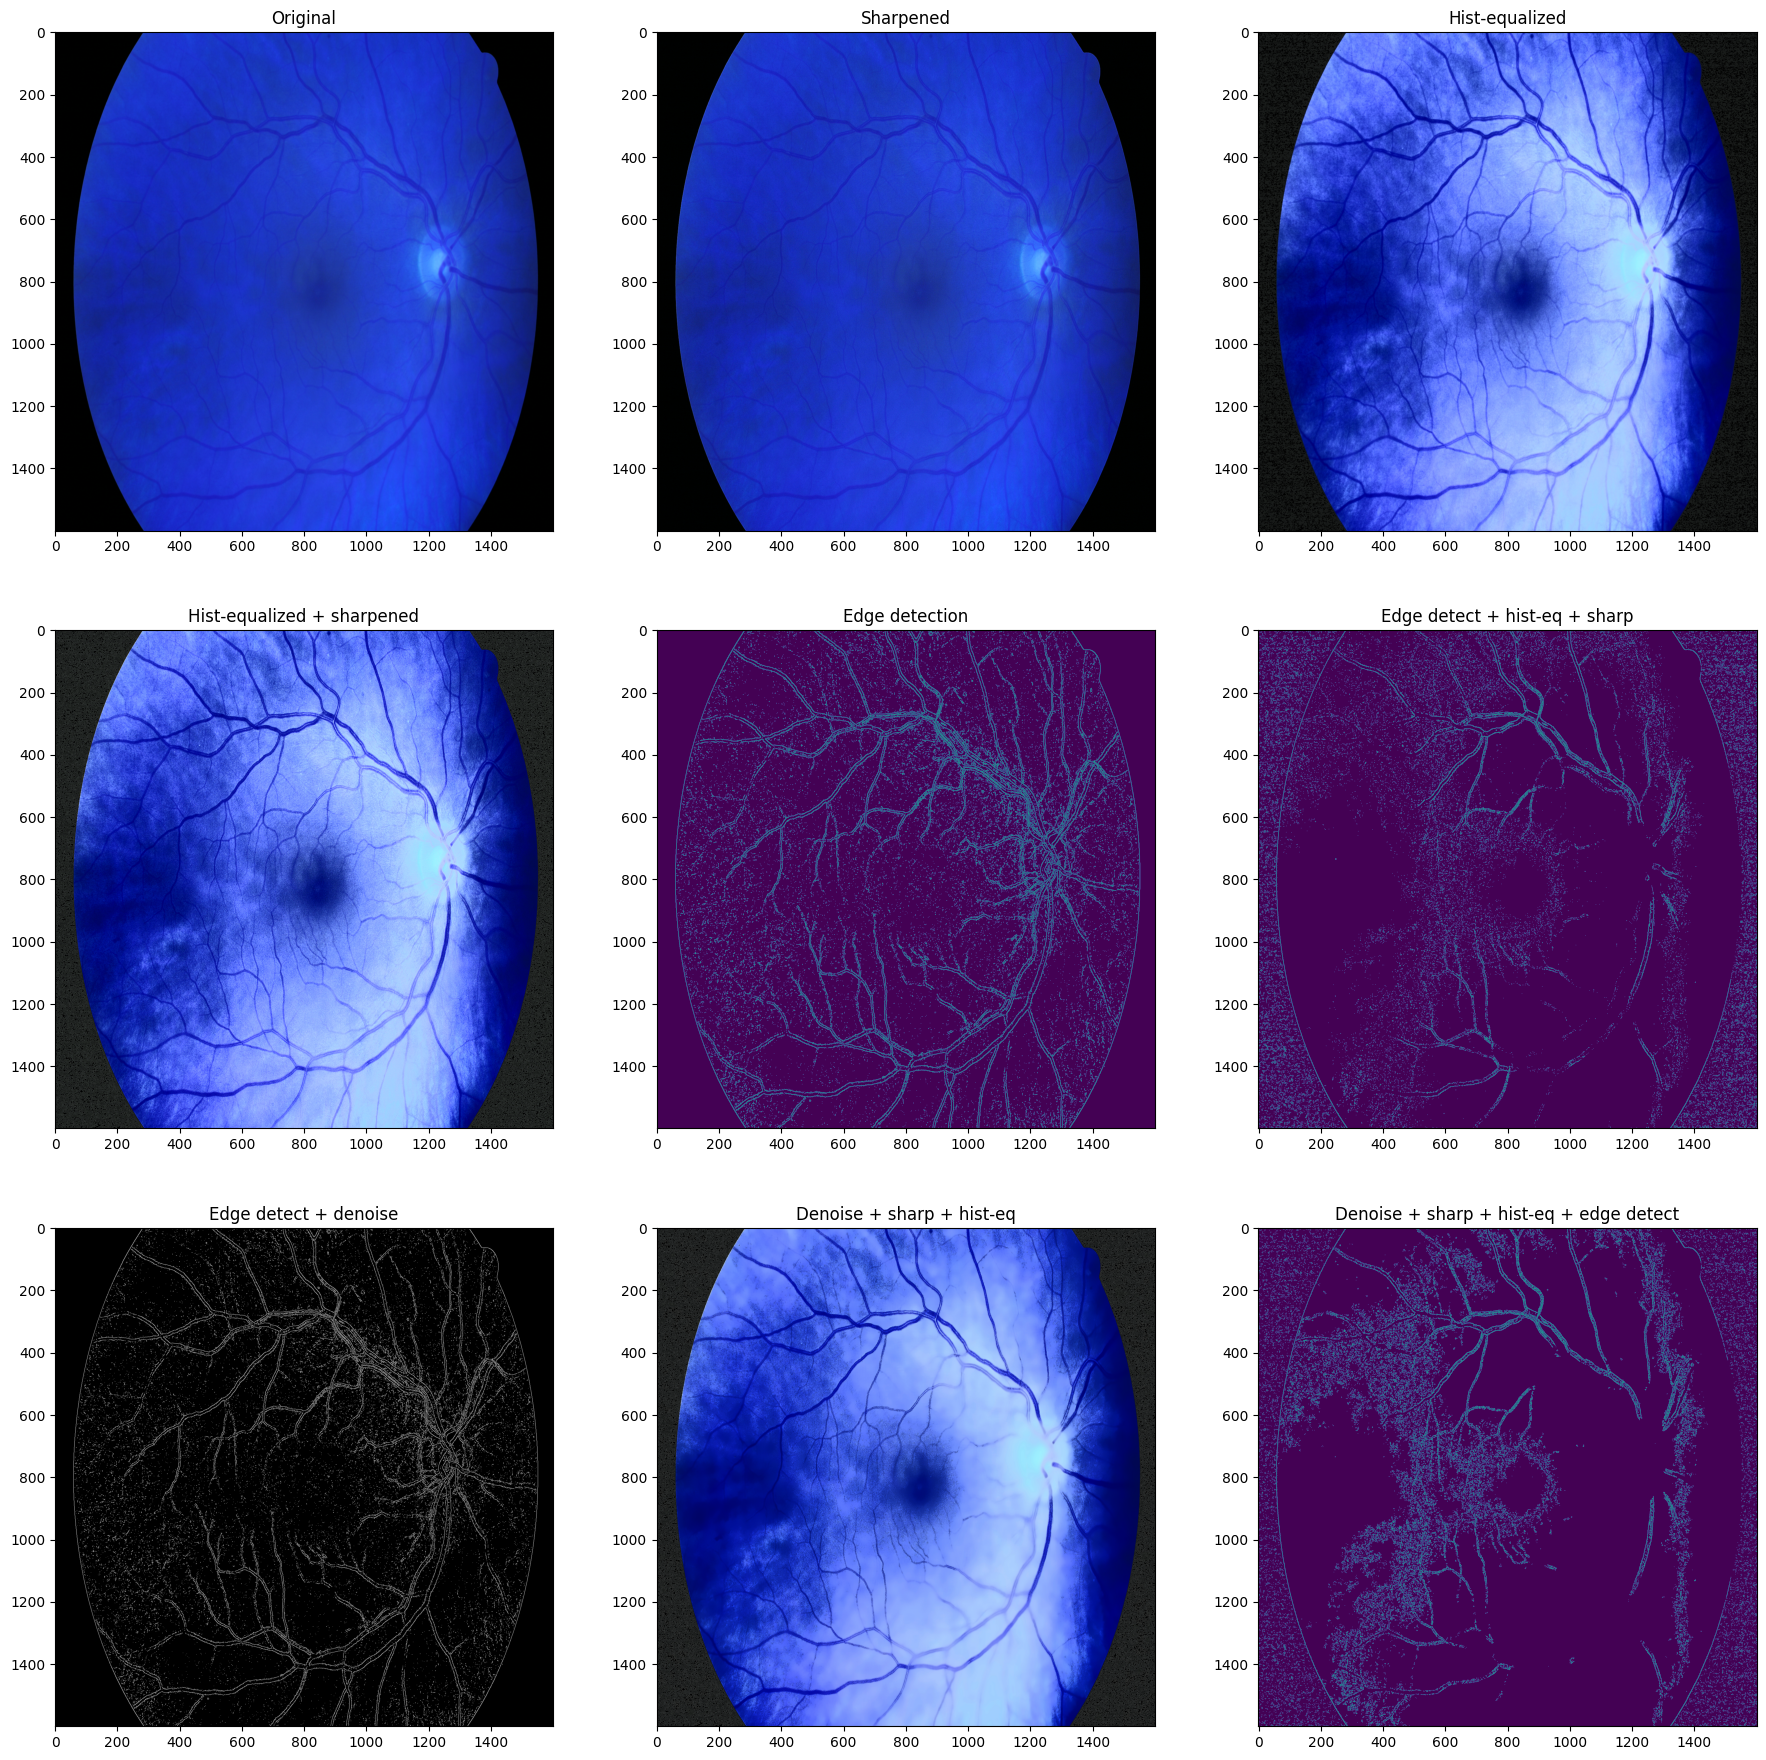

In [142]:
fig, ax = plt.subplots(3, 3, figsize=(22,22))

ax[0,0].imshow(X[1])
ax[0,0].set_title('Original')

ax[0,1].imshow(sharpening(X[1]))
ax[0,1].set_title('Sharpened')

ax[0,2].imshow(hist_equalization(X[1]))
ax[0,2].set_title('Hist-equalized')

ax[1,0].imshow(sharpening(hist_equalization(X[1])))
ax[1,0].set_title('Hist-equalized + sharpened')

ax[1,1].imshow(edge_detection(X[1]))
ax[1,1].set_title('Edge detection')

ax[1,2].imshow(edge_detection(sharpening(hist_equalization(X[1])), lvl=330))
ax[1,2].set_title('Edge detect + hist-eq + sharp')

ax[2,0].imshow(denoising(edge_detection(X[1]), convert=True))
ax[2,0].set_title('Edge detect + denoise')

ax[2,1].imshow(denoising(sharpening(hist_equalization(X[1]))))
ax[2,1].set_title('Denoise + sharp + hist-eq')

ax[2,2].imshow(edge_detection(denoising(sharpening(hist_equalization(X[1]))), lvl=330))
ax[2,2].set_title('Denoise + sharp + hist-eq + edge detect')

plt.show()

## Deep Learning Approach

In [26]:
val_samples = 5
batch_size = 4 

y = 255 - np.array(y)

x_train = np.array(X[:val_samples])
y_train = np.expand_dims(np.array(y[:val_samples]), 3)

x_val = np.array(X[val_samples:])
y_val = np.expand_dims(np.array(y[val_samples:]), 3)

x_train = x_train / 255
y_train = y_train / 255
x_val = x_val / 255
y_val = y_val / 255

y_train[(y_train > 0) & (y_train < 1)] = 0
y_val[(y_val > 0) & (y_val < 1)] = 0

#y_train = y_train.astype('int')
#y_val = y_val.astype('int')

train_datagen = ImageDataGenerator()
        #rotation_range=20,
        #zoom_range=0.2,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #horizontal_flip=True,
        #vertical_flip=True,
        #rescale=1./255)

val_datagen = ImageDataGenerator() #rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

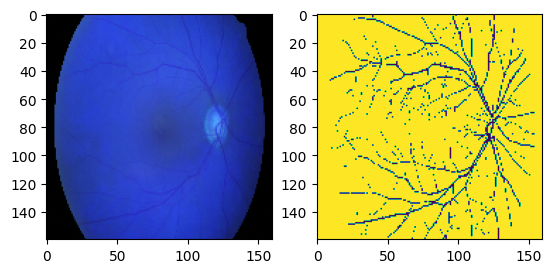

In [28]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(val_generator[0][0][0])
ax[1].imshow(val_generator[0][1][0])
plt.show()

In [29]:
#img_dir = sorted([os.path.join(images_dir, img) for img in images])
#targ_dir = sorted([os.path.join(targets_dir, img) for img in targets])



#random.Random(1337).shuffle(img_dir)
#random.Random(1337).shuffle(targ_dir)
#train_input_img_paths = img_dir[:-val_samples]
#train_target_img_paths = target_dir[:-val_samples]
#val_input_img_paths = img_dir[-val_samples:]
#val_target_img_paths = targ_dir[-val_samples:]

#train_gen = Vessels(
#    batch_size, img_size, train_input_img_paths, train_target_img_paths
#)

#val_gen = Vessels(
#    batch_size, img_size, val_input_img_paths, val_target_img_paths
#)

#K.clear_session()

model = get_model(img_size, num_classes=2)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=['accuracy'])

callbacks = [
    ModelCheckpoint("blood_vessels.h5", save_best_only=True)
]
epochs = 10
# model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)#

In [30]:
model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)

Epoch 1/10
2/2 [==============================] - 5s 550ms/step - loss: 1.3147 - accuracy: 0.5151 - val_loss: 3.8491 - val_accuracy: 0.0373
Epoch 2/10
2/2 [==============================] - 0s 237ms/step - loss: 3.2846 - accuracy: 0.2891 - val_loss: 0.7099 - val_accuracy: 0.7579
Epoch 3/10
2/2 [==============================] - 0s 243ms/step - loss: 1.4233 - accuracy: 0.4953 - val_loss: 0.4819 - val_accuracy: 0.2878
Epoch 4/10
2/2 [==============================] - 0s 238ms/step - loss: 0.9839 - accuracy: 0.5849 - val_loss: 0.4555 - val_accuracy: 0.9946
Epoch 5/10
2/2 [==============================] - 0s 121ms/step - loss: 0.4503 - accuracy: 0.6679 - val_loss: 0.4840 - val_accuracy: 0.9949
Epoch 6/10
2/2 [==============================] - 0s 251ms/step - loss: 0.4148 - accuracy: 0.3350 - val_loss: 0.4167 - val_accuracy: 0.0330
Epoch 7/10
2/2 [==============================] - 0s 132ms/step - loss: 0.3854 - accuracy: 0.5752 - val_loss: 0.4581 - val_accuracy: 0.1048
Epoch 8/10
2/2 [====

In [31]:
pred = model.predict(val_generator)

10/10 [==============================] - 0s 9ms/step


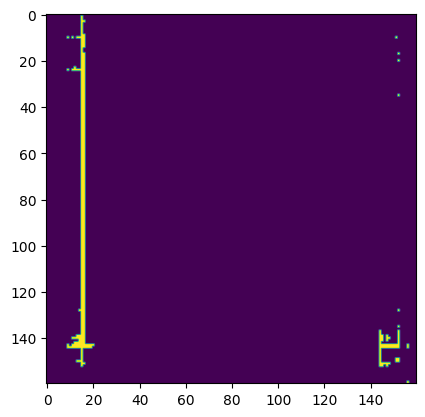

In [34]:
for k in range(len(pred)):

    predicted = np.zeros(img_size)

    for i in range(img_size[0]):
        for j in range(img_size[1]):
            predicted[i,j] = np.argmax(pred[k,i,j])

    plt.imshow(predicted)
    plt.show()
    
    break

In [ ]:
# 90000 / 150 / 150 / 4
# 102400 / 160 / 160 / 4